## Activity and PPGR
Calculates ppgr auc, mets auc, average level, and activeMins metrics with a datetime of each meal for 2hr and 3hr timeframes

In [1]:
import numpy as np
import pandas as pd 
from sklearn.metrics import auc
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime

In [4]:
participant = 1

def libreLinearInterpolation(cgm_df):
    # Convert the 'Date_Time' column to datetime type
    cgm_df['Date_Time'] = pd.to_datetime(cgm_df['Date_Time'])
    # Set the 'Date_Time' column as the index
    cgm_df.set_index('Date_Time', inplace=True)
    # Drop or fill missing values
    cgm_df.dropna(inplace=True)  # Drop rows with missing values
    # Fix duplicate error
    cgm_df = cgm_df.loc[~cgm_df.index.duplicated(), :]
    # Resample the DataFrame to 1-minute intervals and perform linear interpolation
    cgm_df_interpolated = cgm_df.resample('1T').interpolate(method='linear')
    # Reset the index back to a column
    cgm_df_interpolated.reset_index(inplace=True)
    return cgm_df_interpolated

def dexcomLinearInterpolation(raw_cgm_df):
    # Convert the 'Date_Time' column to datetime type
    raw_cgm_df['Date_Time'] = pd.to_datetime(raw_cgm_df['Date_Time'])
    # Set the seconds component to 0
    raw_cgm_df['Date_Time'] = raw_cgm_df['Date_Time'].apply(lambda dt: dt.replace(second=0))
    # Set the 'Date_Time' column as the index
    raw_cgm_df.set_index('Date_Time', inplace=True)
    # Resample the DataFrame to 1-minute intervals and perform linear interpolation
    interpolated_cgm_df = raw_cgm_df.resample('1T').interpolate(method='linear')
    interpolated_cgm_df
    # Reset the index back to a column
    interpolated_cgm_df.reset_index(inplace=True)
    return interpolated_cgm_df

#read datafile for METs
datafile = pd.read_csv(f"C:\\Users\\namil\\Downloads\\CaM01-{str(participant).zfill(3)}_Fitbit.csv")
time = datafile['mins'].to_numpy()
mets = datafile['METs'].to_numpy()
datafile['Date_Time'] = pd.to_datetime(datafile['Date_Time'])

time = time[~np.isnan(time)]
mets = mets[~np.isnan(mets)]

#read cgm datafiles
libredata = libreLinearInterpolation(pd.read_csv(f"C:\\Users\\namil\\Downloads\\CaM01-{str(participant).zfill(3)}_CGM_Libre.csv")) 
dexcomdata = dexcomLinearInterpolation(pd.read_csv(f"C:\\Users\\namil\\Downloads\\CaM01-{str(participant).zfill(3)}_CGM_Dexcom.csv"))

### Calculate metrics for all the meal times from a spreadsheet
can export to csv or print yay

In [93]:
auc2 = []
auc3 = []
activeMin2 = []
activeMin3 = []
avg2 = []
avg3 = []

def activityMetrics(timestring):
    tuples = zip(time,mets)
    arr = np.asarray(list(tuples))

    #find start time
    target_time = datetime.strptime(timestring, '%m/%d/%Y %H:%M')
    theday = datafile[datafile['Date_Time'].dt.date == target_time.date()]
    starttime = theday.iloc[0]['Date_Time']
    minutes = int((target_time - starttime).total_seconds() / 60 + theday.iloc[0]['mins'])

    timeframe = 180
    #filter to time interval
    filtered = arr[arr[:,0] <= minutes + timeframe]
    filtered = filtered[filtered[:,0] >= minutes]
    plt.plot(filtered[:,0], filtered[:,1], label = "mets for 2 hrs")
    plt.legend()
    plt.show()

    #calculate iauc for that time interval
    activity = filtered[:,1]
    area = auc(filtered[:,0], activity)
    
    auc3.append(area)
    avg3.append(np.average(activity)/10)
    activeMin3.append(len(activity[activity > 20]))
#     print("three hours auc:", area)
#     print("three hours average:", np.average(activity)/10)
#     print("three hours activeMins:", len(activity[activity > 20]))

    filtered = filtered[filtered[:,0] <= minutes + 120]
    activity = filtered[:,1]
    area = auc(filtered[:,0], activity)
#     print("two hours auc:", area)
#     print("two hours average:", np.average(activity)/10)
#     print("two hours activeMins:", len(activity[activity > 20]))
    auc2.append(area)
    avg2.append(np.average(activity)/10)
    activeMin2.append(len(activity[activity > 20]))

In [94]:
def iaucAll(timestring, twohr, threehr, libre): 
    datafile = libredata if libre else dexcomdata
    
    time = datafile['mins'].to_numpy()
    bg = datafile['BG'].to_numpy()
    time = time[~np.isnan(time)]
    bg = bg[~np.isnan(bg)]
    datafile['Date_Time'] = pd.to_datetime(datafile['Date_Time'])
    
    target_time = datetime.strptime(timestring, '%m/%d/%Y %H:%M')
    theday = datafile[datafile['Date_Time'].dt.date == target_time.date()]
    starttime = theday.iloc[0]['Date_Time']
    minutes = int((target_time - starttime).total_seconds() / 60 + theday.iloc[0]['mins'])
    
    tuples = zip(time,bg)
    arr = np.asarray(list(tuples))

    #filter to time interval
    filtered = arr[arr[:,0] >= minutes]
    filtered = filtered[filtered[:,0] <= minutes + 180]
    plt.plot(filtered[:,0], filtered[:,1], label = "3 hr")
    plt.legend()
    try:
        area = auc(filtered[:,0], filtered[:,1])
        #check that start and end pts are available (will look for a better way later)
        checkstart = filtered[filtered[:,0] == minutes]
        checkend = filtered[filtered[:,0] == minutes + 180]
        if len(checkstart) == 0 or len(checkend) == 0:
             raise ValueError('Endpoint not available')
            
    except ValueError:
        area = "error"
    threehr.append(area)

    filtered = filtered[filtered[:,0] <= minutes + 120]
    plt.plot(filtered[:,0], filtered[:,1], label = "2 hr")
   
    #calculate iauc for that time interval
    try:
        area = auc(filtered[:,0], filtered[:,1])
    except ValueError:
        area = "error"
    twohr.append(area)
    plt.show()



9/18/2021 11:21
three hours auc: 3390.5
three hours average: 1.8867403314917126
three hours activeMins: 66
two hours auc: 1866.0
two hours average: 1.5677685950413225
two hours activeMins: 33
3 hr: 13642.2
2 hr 8897.099999999999


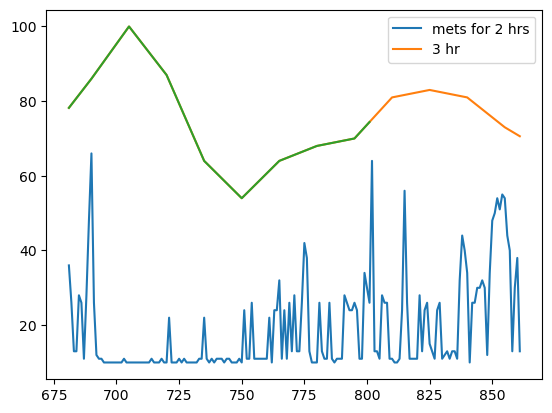

3 hr: error
2 hr 12011.6


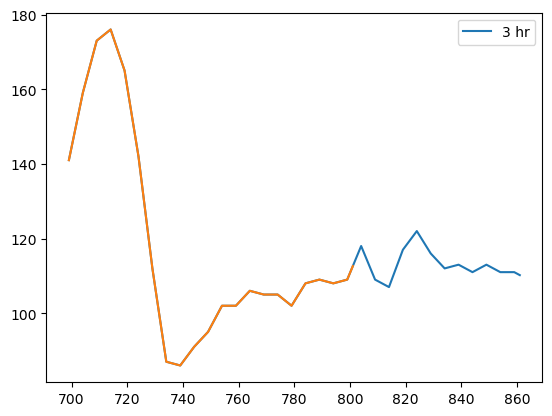


9/18/2021 14:23
three hours auc: 6140.0
three hours average: 3.407734806629834
three hours activeMins: 105
two hours auc: 3067.0
two hours average: 2.584297520661157
two hours activeMins: 57
3 hr: 14896.533333333333
2 hr 9865.333333333332


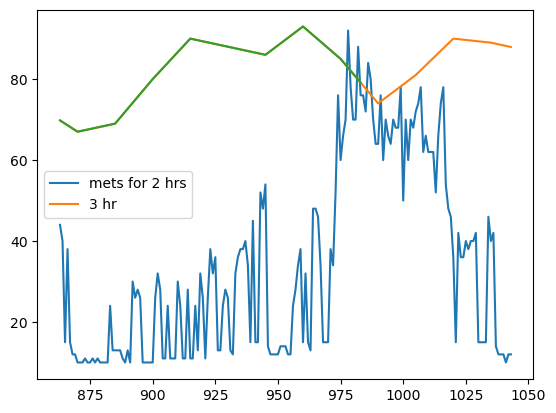

3 hr: 21231.5
2 hr 13865.2


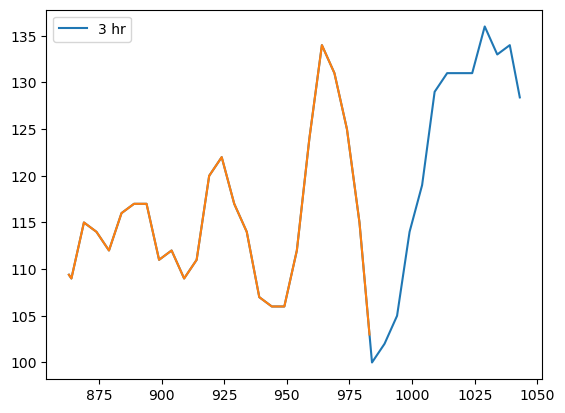


9/18/2021 20:48
three hours auc: 2029.5
three hours average: 1.127624309392265
three hours activeMins: 10
two hours auc: 1423.5
two hours average: 1.1859504132231407
two hours activeMins: 10
3 hr: 17330.1
2 hr 11802.599999999999


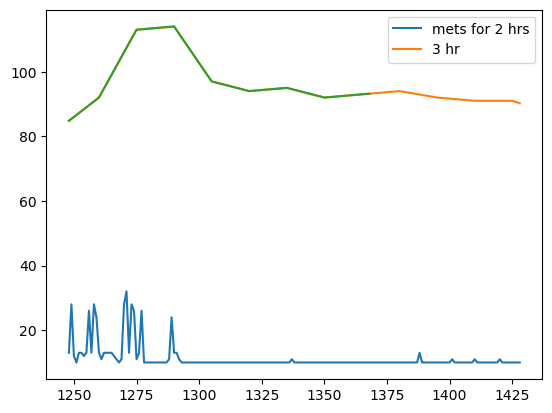

3 hr: 22573.199999999997
2 hr 15192.900000000001


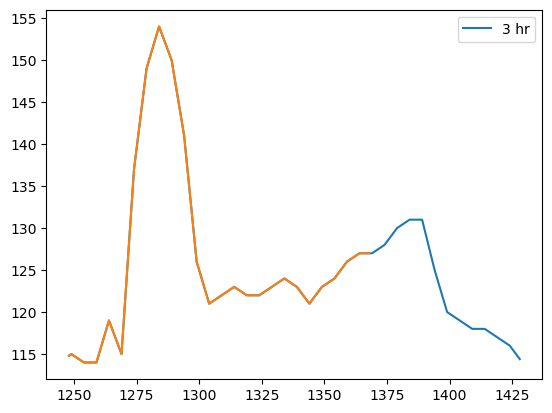


9/19/2021 8:18
three hours auc: 8796.0
three hours average: 4.879558011049724
three hours activeMins: 118
two hours auc: 3656.5
two hours average: 3.0826446280991737
two hours activeMins: 60
3 hr: 16775.4
2 hr 11859.3


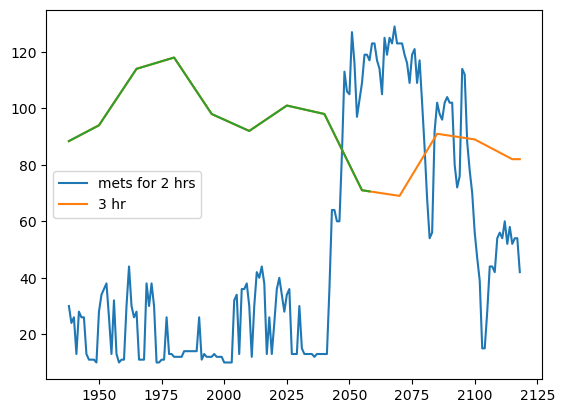

3 hr: 17879.1
2 hr 13179.5


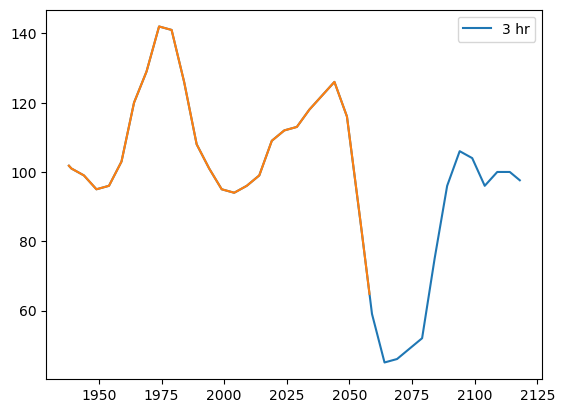


9/19/2021 12:00
three hours auc: 2388.0
three hours average: 1.3298342541436463
three hours activeMins: 23
two hours auc: 1787.0
two hours average: 1.4925619834710744
two hours activeMins: 23
3 hr: 15817.5
2 hr 10747.5


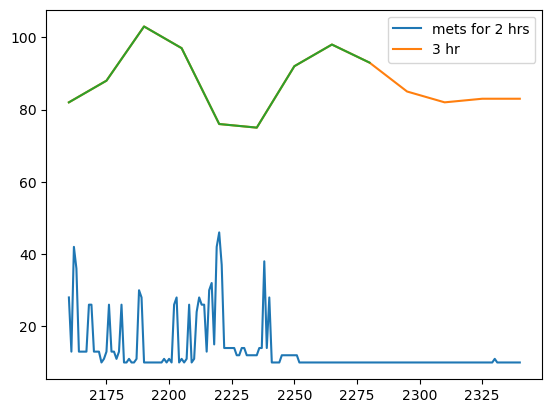

3 hr: 15507.399999999998
2 hr 10549.7


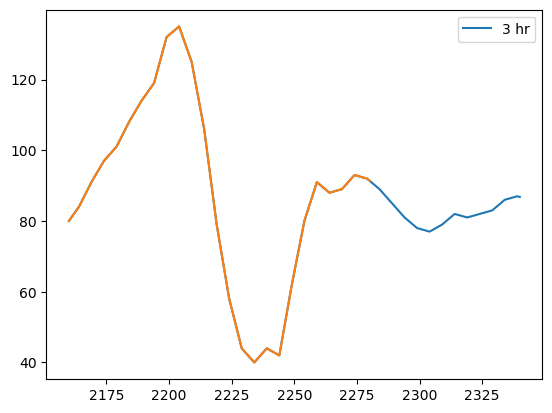


9/19/2021 20:10
three hours auc: 3156.5
three hours average: 1.7502762430939227
three hours activeMins: 47
two hours auc: 2533.5
two hours average: 2.103305785123967
two hours activeMins: 46
3 hr: 15797.5
2 hr 10741.666666666666


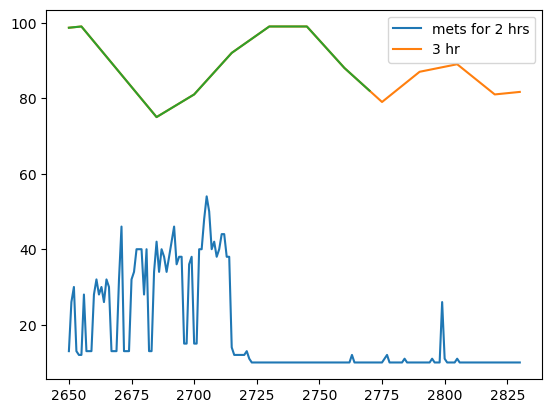

3 hr: 19055.0
2 hr 12937.7


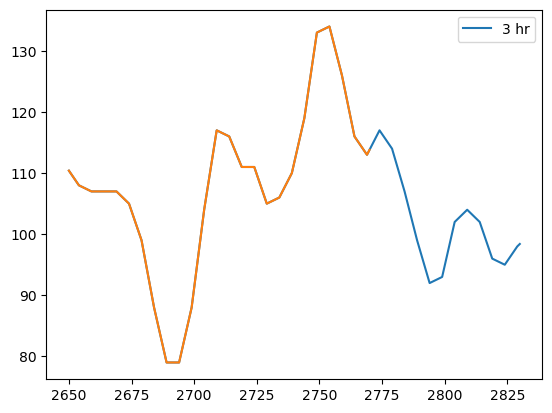


9/20/2021 9:07
three hours auc: 3622.0
three hours average: 2.0082872928176796
three hours activeMins: 65
two hours auc: 2579.0
two hours average: 2.1421487603305787
two hours activeMins: 45
3 hr: 15956.733333333334
2 hr 10973.966666666665


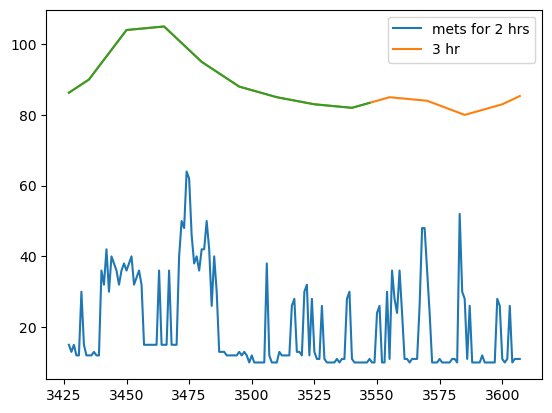

3 hr: 17500.500000000004
2 hr 11938.900000000001


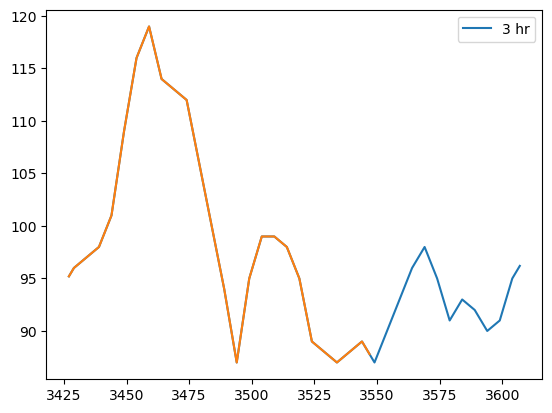


9/20/2021 14:51
three hours auc: 3646.0
three hours average: 2.0303867403314917
three hours activeMins: 67
two hours auc: 2134.0
two hours average: 1.7917355371900825
two hours activeMins: 34
3 hr: 15600.0
2 hr 10208.099999999999


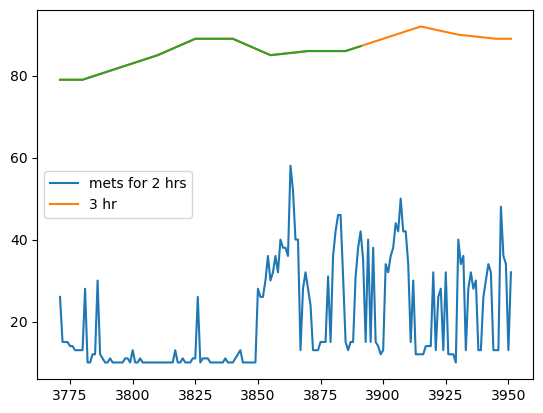

3 hr: 17697.399999999998
2 hr 11639.9


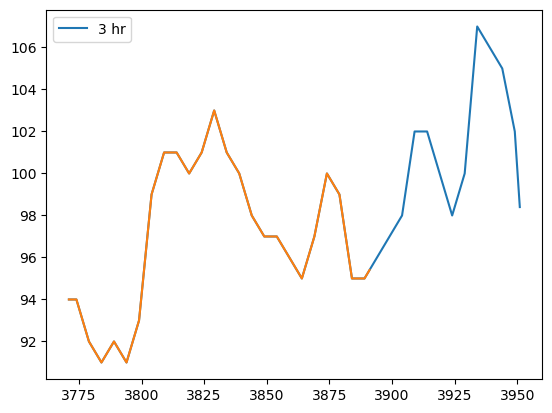


9/20/2021 19:52
three hours auc: 5452.0
three hours average: 3.028729281767956
three hours activeMins: 121
two hours auc: 3955.0
two hours average: 3.288429752066116
two hours activeMins: 91
3 hr: 16063.266666666665
2 hr 10383.033333333333


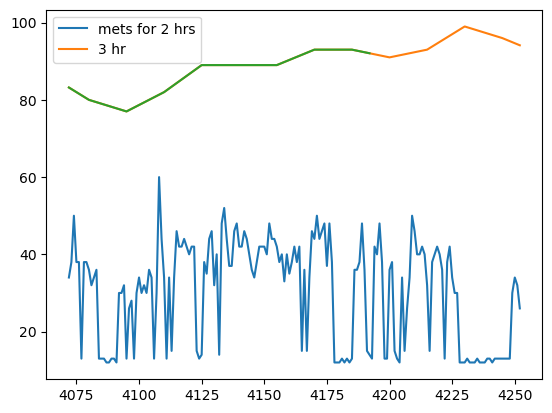

3 hr: 17593.4
2 hr 11304.0


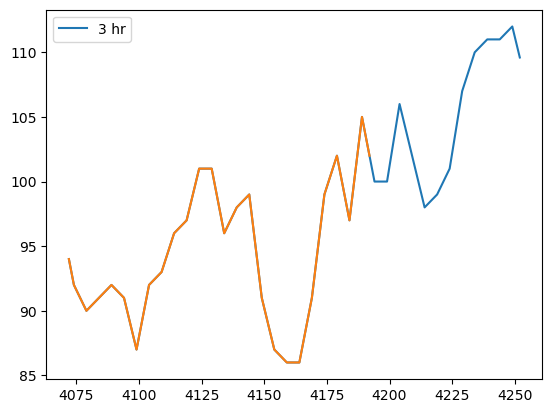


9/21/2021 9:17
three hours auc: 3061.5
three hours average: 1.7132596685082873
three hours activeMins: 45
two hours auc: 1628.5
two hours average: 1.377685950413223
two hours activeMins: 17
3 hr: 16090.333333333332
2 hr 11130.766666666666


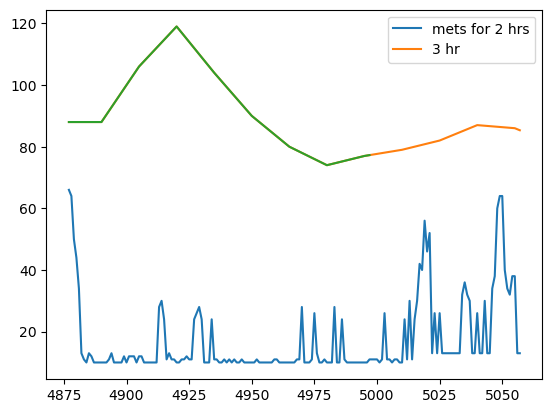

3 hr: 19924.0
2 hr 13973.4


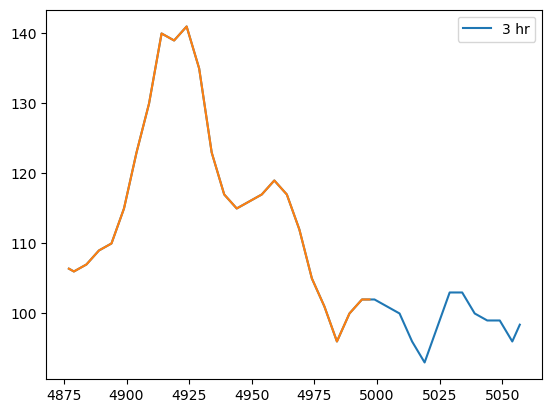


9/21/2021 12:59
three hours auc: 2341.5
three hours average: 1.3
three hours activeMins: 24
two hours auc: 1535.5
two hours average: 1.278512396694215
two hours activeMins: 15
3 hr: 18111.166666666664
2 hr 12336.166666666668


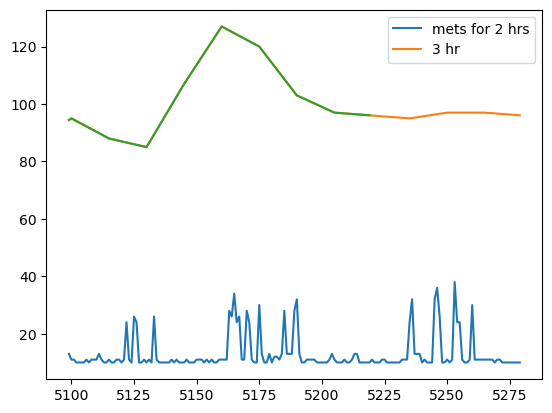

3 hr: 20617.5
2 hr 13780.0


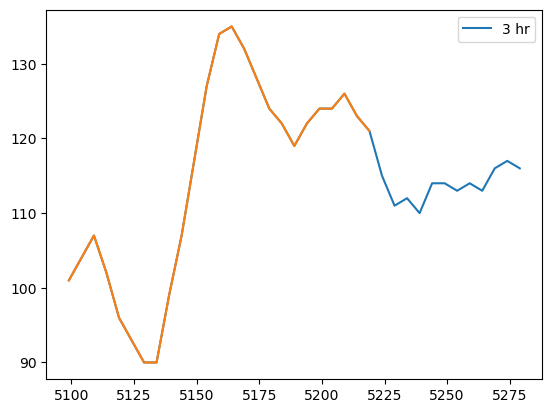


9/21/2021 19:42
three hours auc: 3237.5
three hours average: 1.7950276243093923
three hours activeMins: 51
two hours auc: 2517.5
two hours average: 2.0966942148760332
two hours activeMins: 47
3 hr: 15698.999999999998
2 hr 10142.1


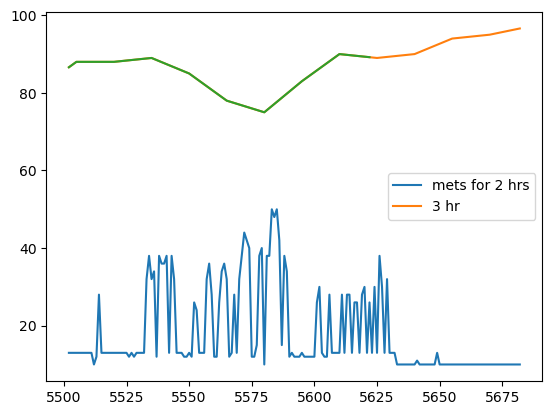

3 hr: 17595.6
2 hr 11144.2


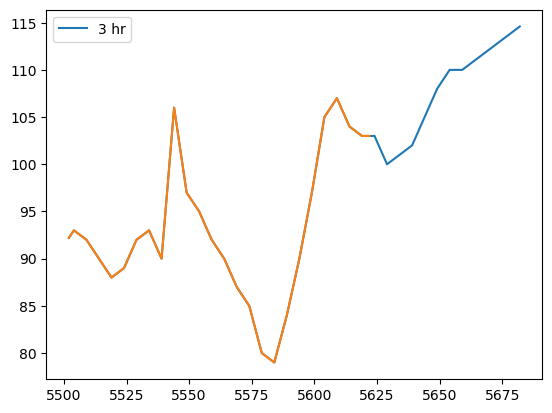


9/22/2021 9:22
three hours auc: 2396.5
three hours average: 1.33646408839779
three hours activeMins: 22
two hours auc: 1613.0
two hours average: 1.3603305785123967
two hours activeMins: 13
3 hr: 16005.366666666667
2 hr 11096.833333333332


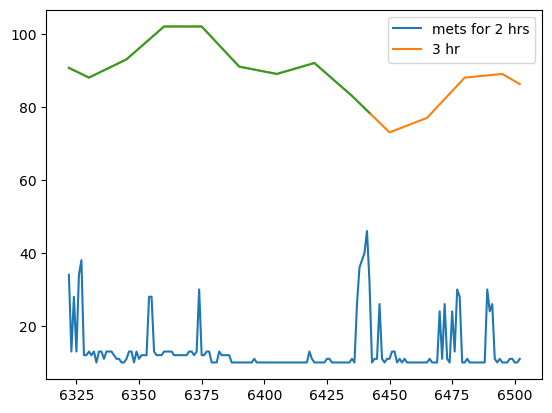

3 hr: 19440.300000000003
2 hr 13626.7


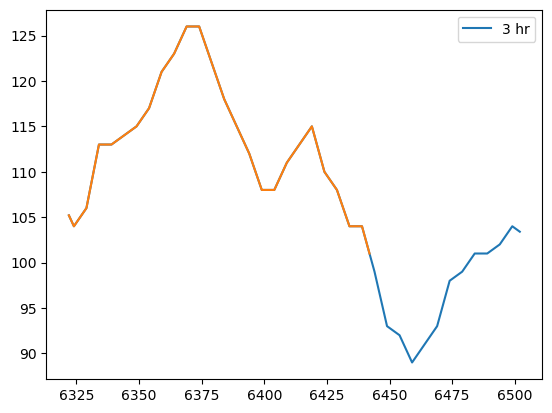


9/22/2021 13:16
three hours auc: 2790.0
three hours average: 1.558011049723757
three hours activeMins: 43
two hours auc: 1531.5
two hours average: 1.2826446280991735
two hours activeMins: 12
3 hr: 15134.2
2 hr 10246.2


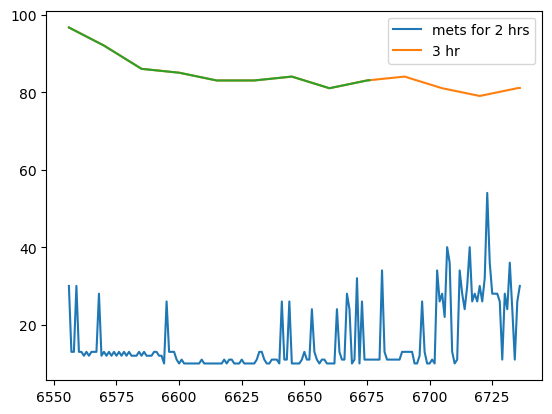

3 hr: 17391.4
2 hr 12097.2


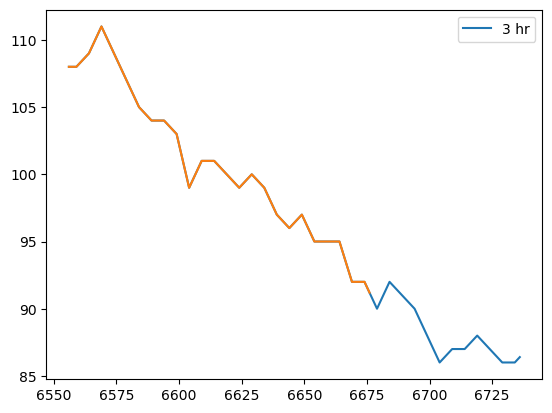


9/22/2021 21:05
three hours auc: 3319.0
three hours average: 1.8403314917127074
three hours activeMins: 54
two hours auc: 2588.5
two hours average: 2.1487603305785123
two hours activeMins: 47
3 hr: 16935.833333333336
2 hr 10777.5


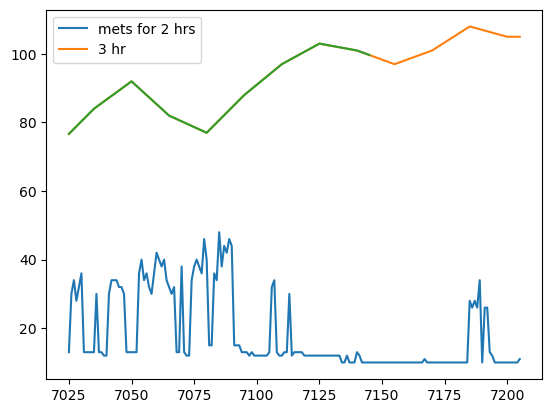

3 hr: 17952.9
2 hr 11480.3


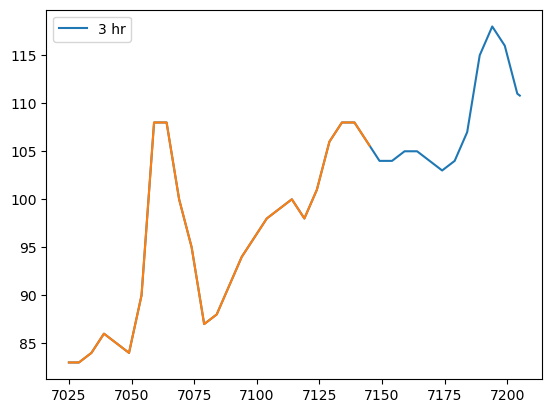


9/23/2021 8:54
three hours auc: 3196.5
three hours average: 1.7723756906077348
three hours activeMins: 53
two hours auc: 2120.5
two hours average: 1.7619834710743802
two hours activeMins: 37
3 hr: 16257.9
2 hr 11082.9


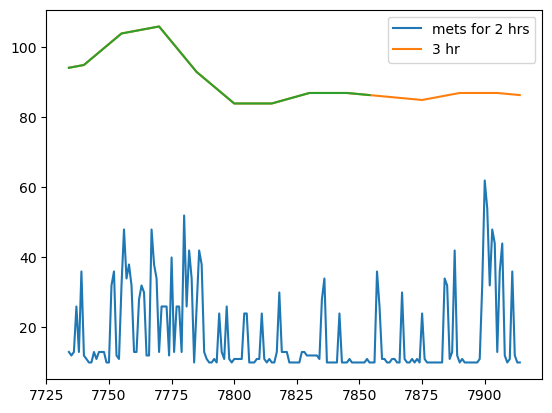

3 hr: 19287.5
2 hr 13015.0


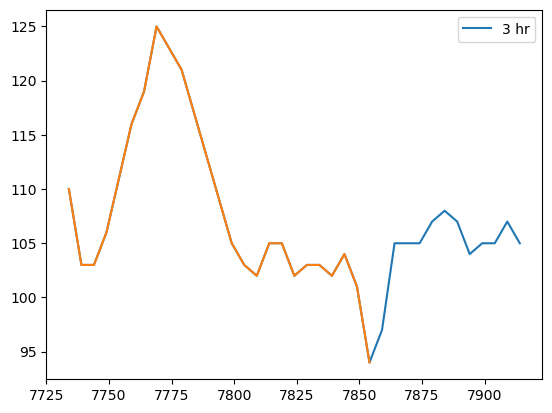


9/23/2021 12:25
three hours auc: 4599.5
three hours average: 2.5475138121546963
three hours activeMins: 103
two hours auc: 3459.0
two hours average: 2.8694214876033057
two hours activeMins: 82
3 hr: 16387.5
2 hr 10985.833333333332


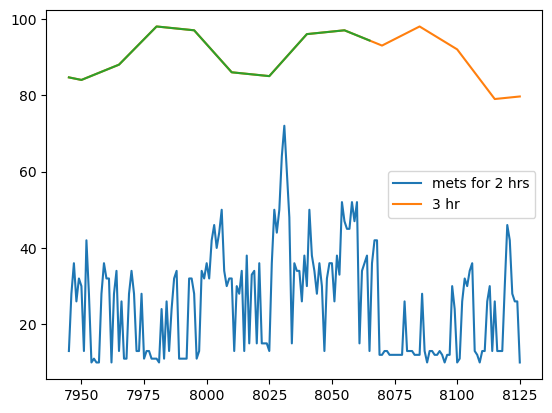

3 hr: 19295.800000000003
2 hr 12883.6


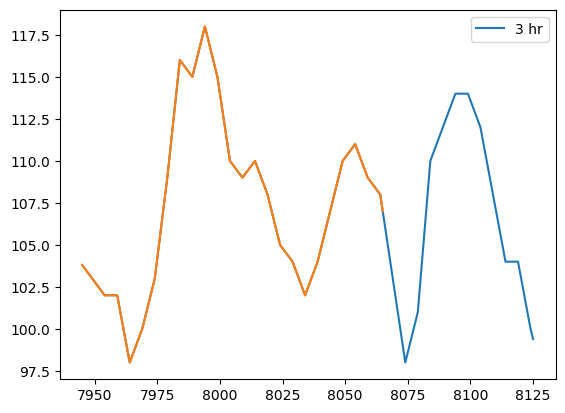


9/23/2021 19:56
three hours auc: 2878.5
three hours average: 1.6022099447513813
three hours activeMins: 44
two hours auc: 1626.5
two hours average: 1.352892561983471
two hours activeMins: 18
3 hr: 14886.533333333333
2 hr 10119.3


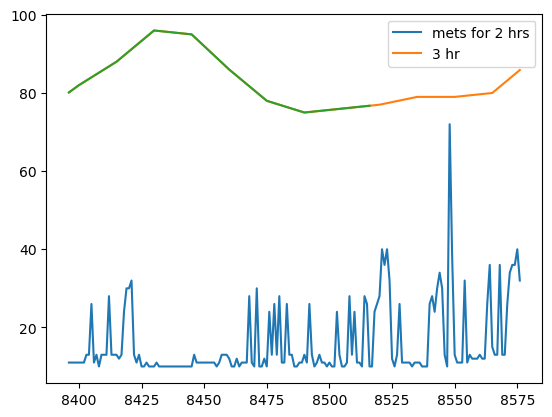

3 hr: 17262.1
2 hr 11229.1


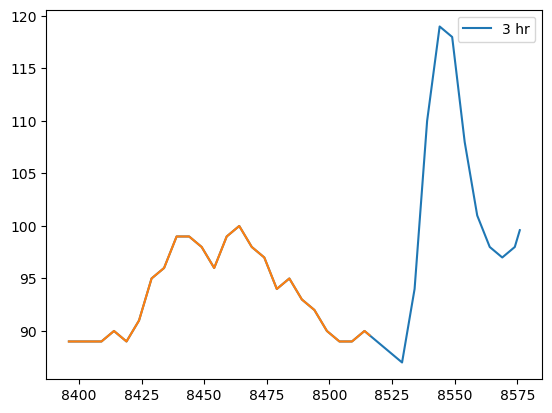


9/23/2021 21:19
three hours auc: 3549.0
three hours average: 1.9679558011049725
three hours activeMins: 71
two hours auc: 2185.5
two hours average: 1.8165289256198345
two hours activeMins: 40
3 hr: 15028.133333333335
2 hr 9665.066666666666


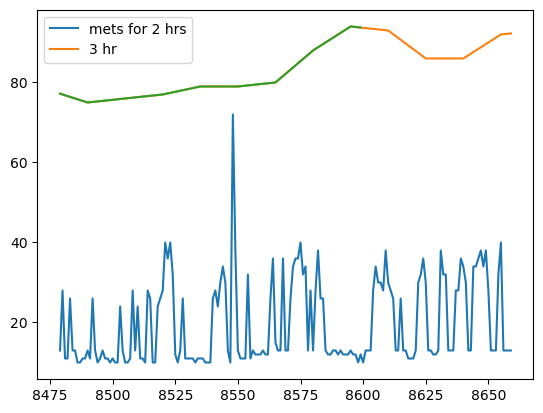

3 hr: 18690.0
2 hr 11960.0


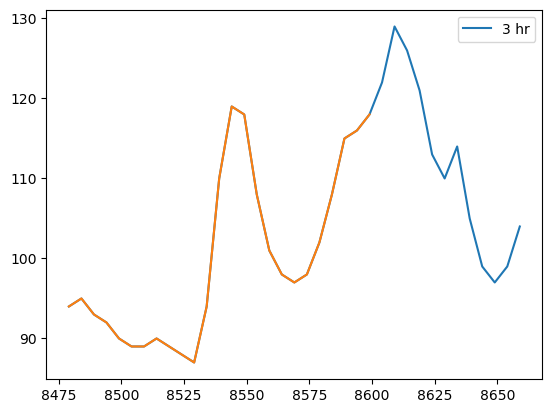


9/24/2021 10:07
three hours auc: 4885.0
three hours average: 2.7116022099447514
three hours activeMins: 108
two hours auc: 2890.5
two hours average: 2.4074380165289258
two hours activeMins: 67
3 hr: 17346.133333333335
2 hr 12197.433333333332


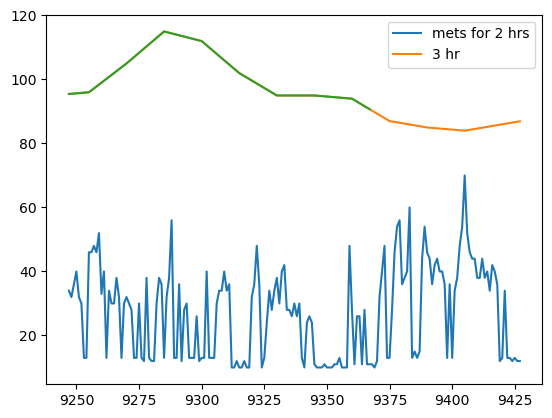

3 hr: 20886.0
2 hr 14541.9


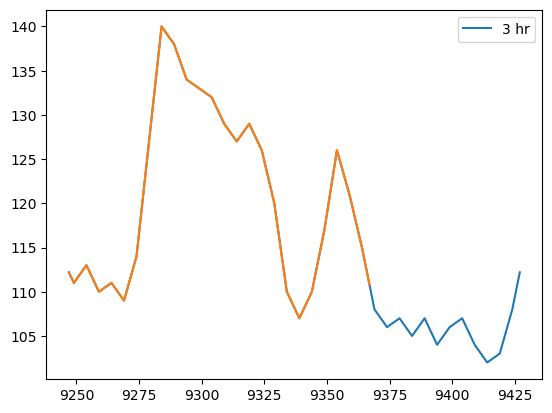


9/24/2021 14:12
three hours auc: 5070.5
three hours average: 2.8132596685082873
three hours activeMins: 130
two hours auc: 3227.0
two hours average: 2.693388429752066
two hours activeMins: 85
3 hr: 17872.800000000003
2 hr 11949.9


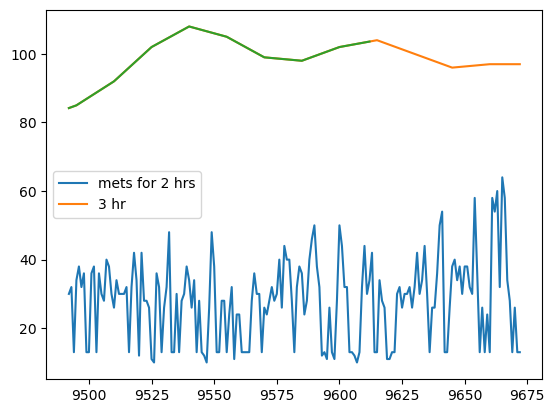

3 hr: 20055.7
2 hr 13181.1


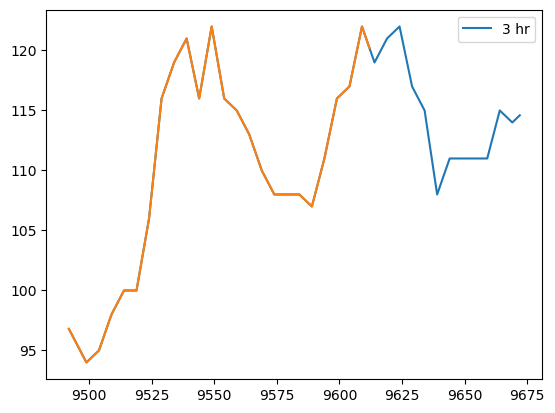


9/24/2021 19:36
three hours auc: 2803.0
three hours average: 1.558011049723757
three hours activeMins: 42
two hours auc: 1916.0
two hours average: 1.606611570247934
two hours activeMins: 31
3 hr: 17564.700000000004
2 hr 11466.3


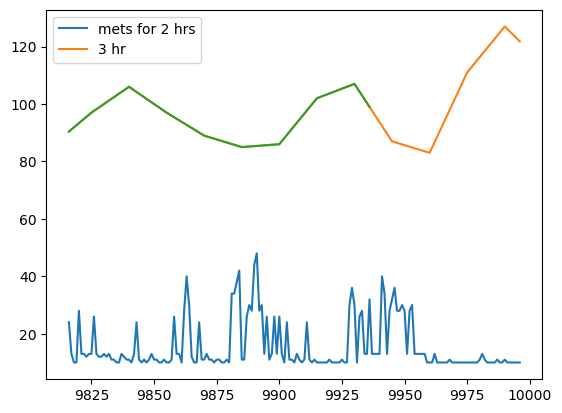

3 hr: 20019.1
2 hr 12789.9


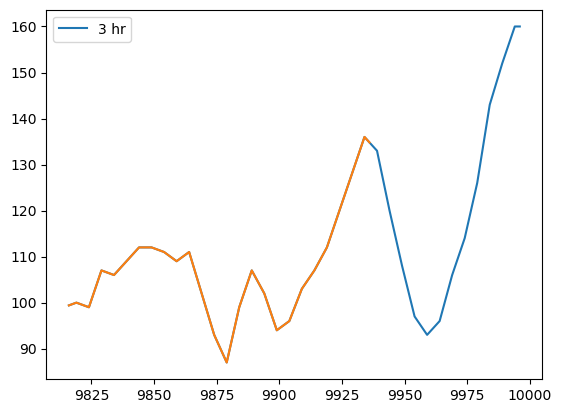


9/25/2021 9:58
three hours auc: 5812.0
three hours average: 3.230386740331492
three hours activeMins: 106
two hours auc: 4671.5
two hours average: 3.881818181818182
two hours activeMins: 92
3 hr: 16653.266666666666
2 hr 11290.599999999999


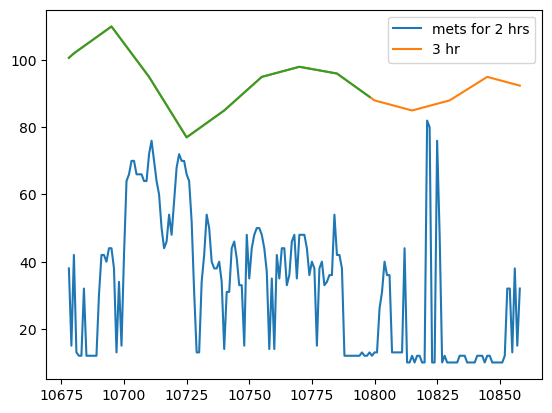

3 hr: 20785.4
2 hr 14011.600000000002


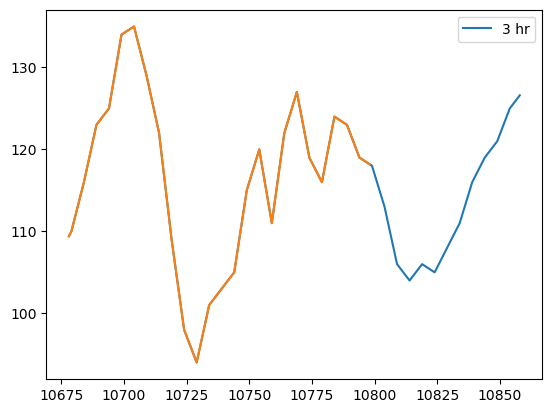


9/25/2021 13:26
three hours auc: 7633.0
three hours average: 4.24475138121547
three hours activeMins: 123
two hours auc: 3902.0
two hours average: 3.267768595041322
two hours activeMins: 67
3 hr: 14186.8
2 hr 9266.8


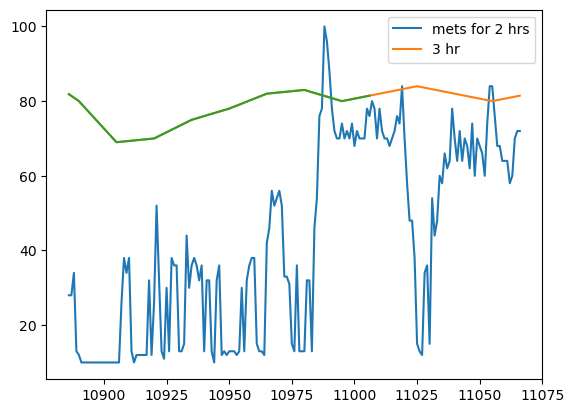

3 hr: 17834.5
2 hr 11640.2


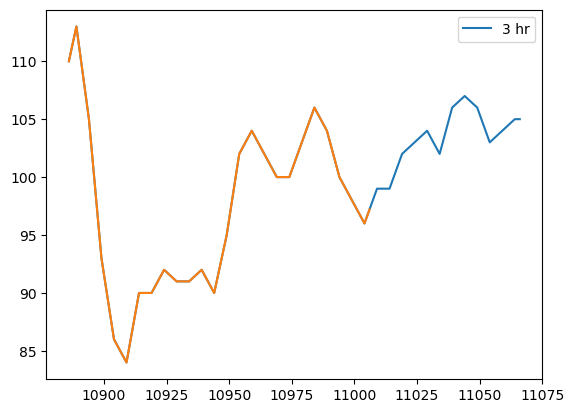


9/25/2021 20:16
three hours auc: 3647.5
three hours average: 2.0281767955801104
three hours activeMins: 62
two hours auc: 2310.5
two hours average: 1.9256198347107438
two hours activeMins: 36
3 hr: 19000.533333333333
2 hr 12711.333333333332


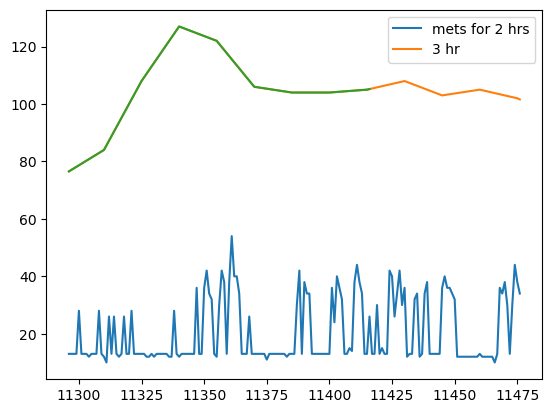

3 hr: 22317.9
2 hr 14985.0


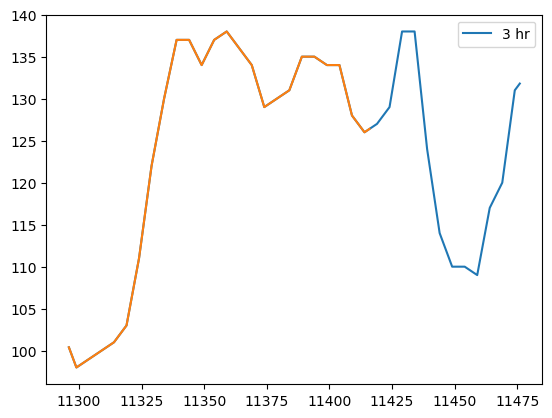


9/26/2021 9:35
three hours auc: 8205.5
three hours average: 4.55414364640884
three hours activeMins: 130
two hours auc: 5094.5
two hours average: 4.245454545454545
two hours activeMins: 80
3 hr: 16147.5
2 hr 11319.166666666668


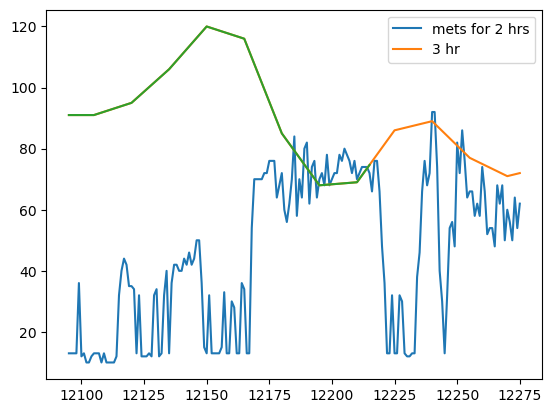

3 hr: 20064.9
2 hr 13852.3


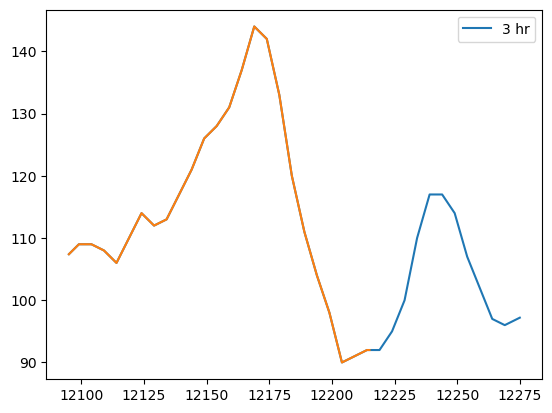


9/26/2021 13:46
three hours auc: 4141.0
three hours average: 2.305524861878453
three hours activeMins: 85
two hours auc: 2764.0
two hours average: 2.3107438016528925
two hours activeMins: 56
3 hr: 15054.133333333333
2 hr 10255.333333333334


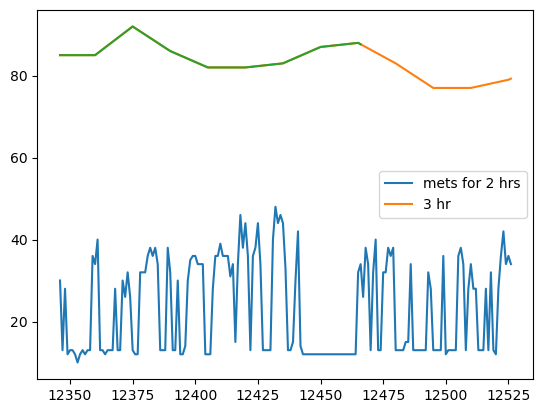

3 hr: 18880.5
2 hr 12876.0


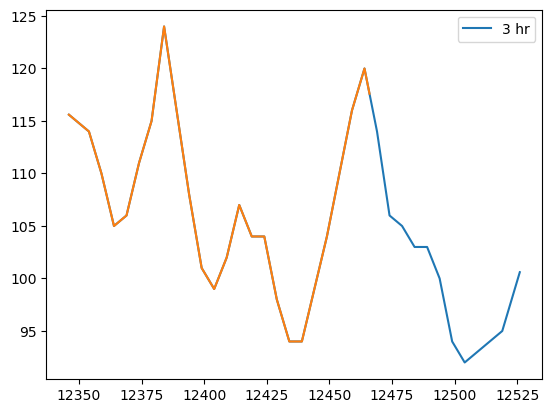


9/26/2021 18:26
three hours auc: 3872.0
three hours average: 2.14585635359116
three hours activeMins: 67
two hours auc: 3191.5
two hours average: 2.6479338842975206
two hours activeMins: 63
3 hr: 18421.5
2 hr 12393.433333333334


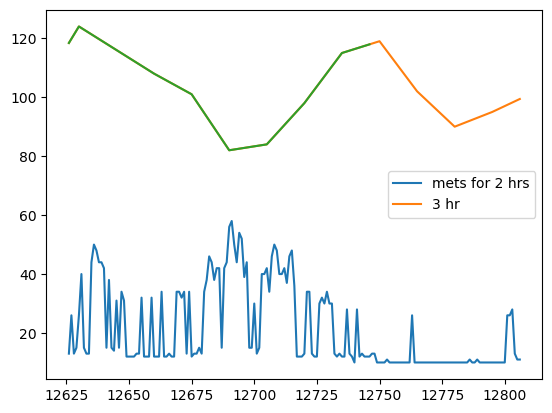

3 hr: 23556.1
2 hr 15608.2


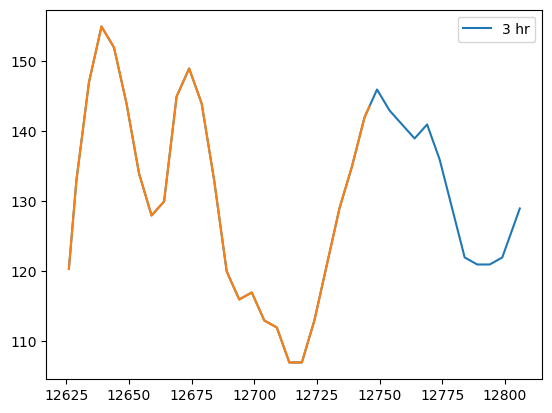


9/27/2021 9:27
three hours auc: 2374.5
three hours average: 1.330939226519337
three hours activeMins: 26
two hours auc: 1508.5
two hours average: 1.2619834710743802
two hours activeMins: 13
3 hr: 15658.2
2 hr 10886.4


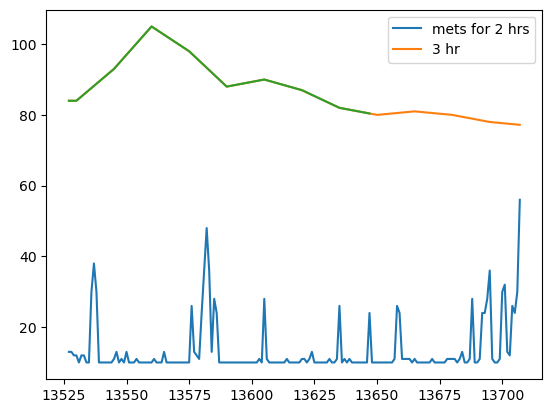

3 hr: 21238.899999999998
2 hr 14650.0


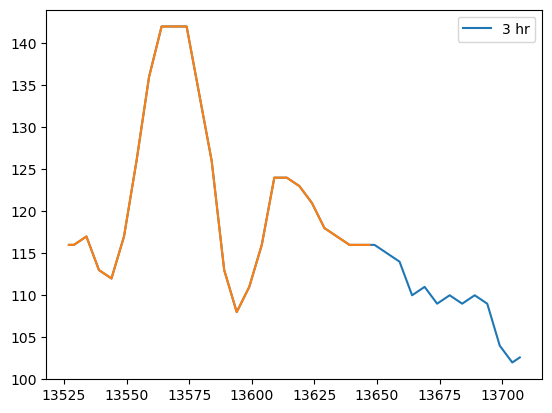


9/27/2021 12:47
three hours auc: 2701.0
three hours average: 1.5104972375690608
three hours activeMins: 35
two hours auc: 1964.5
two hours average: 1.6446280991735538
two hours activeMins: 28
3 hr: 15916.166666666664
2 hr 10688.466666666667


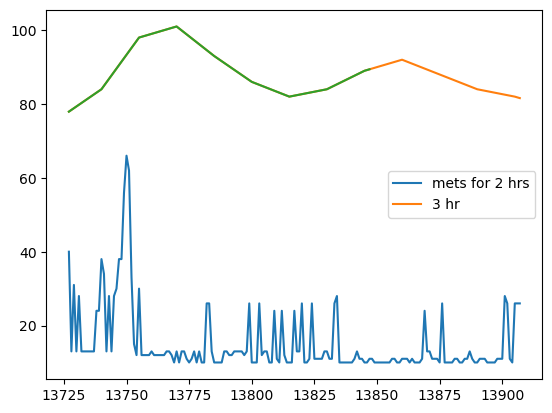

3 hr: 21494.6
2 hr 14304.599999999999


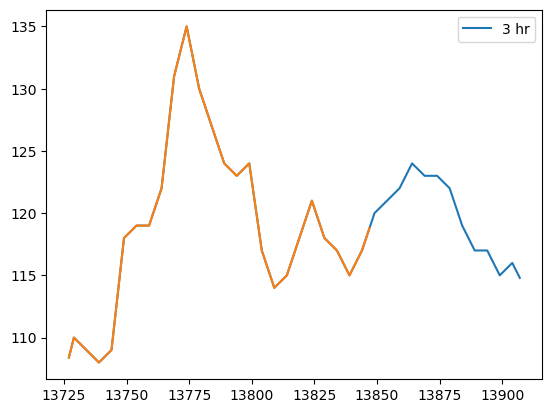


9/27/2021 20:00
three hours auc: 3026.5
three hours average: 1.6784530386740333
three hours activeMins: 44
two hours auc: 2412.5
two hours average: 2.003305785123967
two hours activeMins: 44
3 hr: 15615.0
2 hr 9862.5


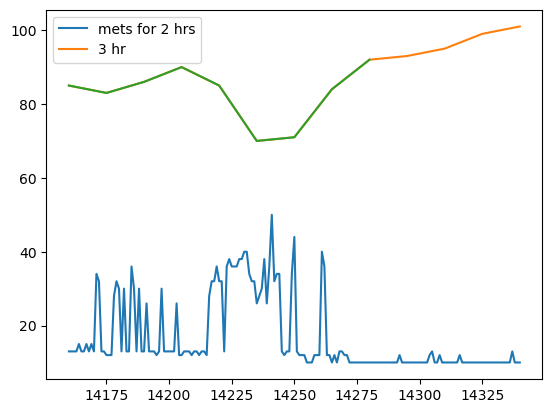

3 hr: 20663.800000000003
2 hr 12595.0


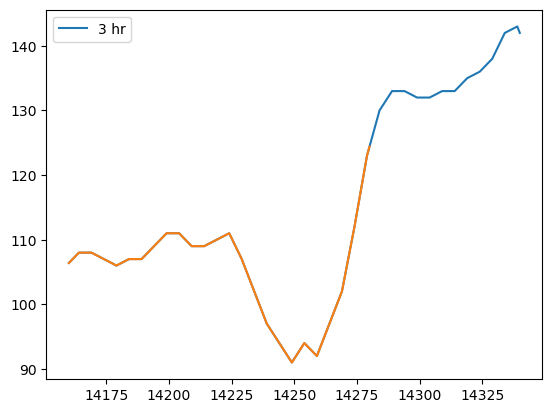


9/28/2021 10:58
three hours auc: 2339.0
three hours average: 1.3088397790055248
three hours activeMins: 22
two hours auc: 1609.0
two hours average: 1.3438016528925618
two hours activeMins: 16
3 hr: 16845.733333333334
2 hr 11311.0


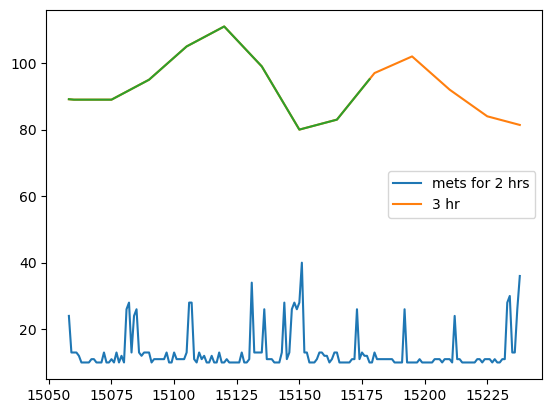

3 hr: error
2 hr error


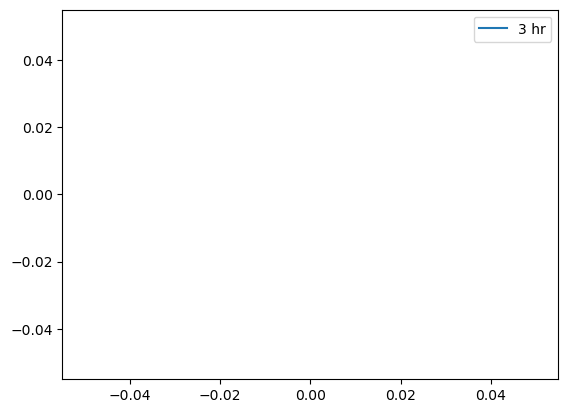

In [92]:
twohr = []
threehr = []
dtwo = []
dthree = []
auc2 = []
auc3 = []
activeMin2 = []
activeMin3 = []
avg2 = []
avg3 = []

mldata = pd.read_csv(f"C:\\Users\\namil\\Downloads\\00{participant}.csv").dropna()
# mldata = pd.read_csv(f"C:\\Users\\namil\\Downloads\\food.csv").dropna()
mldata['Meal Time'] = mldata['Meal Time'].to_numpy()

for i in mldata['Meal Time']:
    print('\n' + i)
    activityMetrics(str(i))
    iaucAll(str(i), twohr, threehr, 1)
    iaucAll(str(i), dtwo, dthree, 0)

df = pd.DataFrame({'ppgr 2 hr': twohr, 'ppgr 3 hr': threehr, 
                   'two hr auc': auc2, 'two hr activeMin': activeMin2, 'two hr avg': avg2, 
                   'three hr auc': auc3, 'three hr activeMin': activeMin3, 'three hr avg': avg3,
                  'd2': dtwo, 'd3':dthree})
df.to_csv(f'allmetrics{participant}')